# Transform LineItemContributions

## Order of Ops

#### 1. Remove Blank Contact ID / Contribution ID - these are the same
Can either remove:
- blank Contact IDs `Line Item Contribution - Contribution Contact: Contact ID`
- blank Contribution IDs - `Line Item Contribution: Contribution ID`

*What do we do with these records?*

Do they need to be followd up? e.g., are they failed transactions or transactions that are valid but somehow not properly recorded?

*Is this a Dependency to moving forward with migration?*

NO (TBC)

#### 2. Remove Duplicate Contribution ID records - do all duplicates come in sets of 2?

*Do we collapse these records into a single contribution record?*

YES - *need rules from someone - Michaeal?*

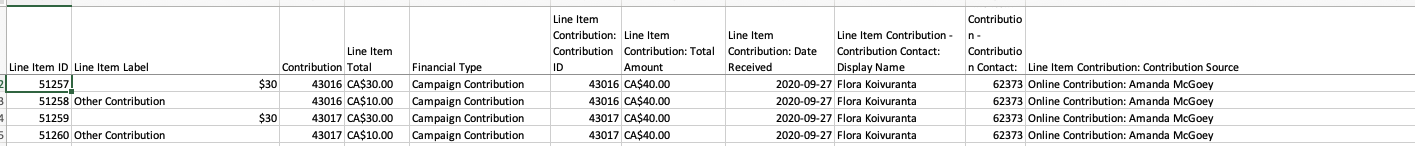

In [1]:
import pandas as pd
from pathlib import Path
 

In [2]:
# Set the EXTRACT, TRANSFORM, LOAD directories
# in a default environment setup, these would be relative to this .ipynb (or .py if this notebook has been converted) 

extract_dir="./01.DataExtract"
transform_dir="./02.DataTransform"
load_dir="./03.DataLoad"


In [ ]:
# loop through the files to load and concatenate

filenames_input =[
"ME_LineItemContributions_Table_1 (0).csv",
"ME_LineItemContributions_Table_1 (1).csv",
"ME_LineItemContributions_Table_1 (2).csv",
"ME_LineItemContributions_Table_1 (3).csv",
"ME_LineItemContributions_Table_1 (4).csv"
]

# name of the concatenated file
filename_output = "ME_LineItemContributions_Table_1"

dataframes = []
for filename in filenames_input:
    df = pd.read_csv(extract_dir+"/"+filename)
    dataframes.append(df)

df_concatd = pd.concat(dataframes)
df_concatd.to_csv(transform_dir+"/"+filename_output+".csv", header=True, index=False)

print(df_concatd)

df_withDupes = df_concatd

In [ ]:
# get/set parameters here

# initial input file
file_withDupes = Path(
    transform_dir + "/" +
    filename_output +
    ".csv")

# get the name of the column to check for duplicates
# set the default here if user does not provide:
defaultdedupeField = "Line Item Contribution: Contribution ID"

dedupeField = input(f"\nEnter name of column to check for duplicates - no value will default to: '{defaultdedupeField}'\n")
if dedupeField == "":
    dedupeField = defaultdedupeField
    print(dedupeField)
    
# get whether to keep first or last record as the master
keepRecord = input(f"\nEnter record to keep. Valid values are 'first' or 'last' - no value will default 'first'\n")
if keepRecord == "":
    keepRecord = "first" 
    print(keepRecord)

In [ ]:
# This section defines the output filenames

# file of ALL records that are part of a set of records with identical ContactIDs will be named:
# [file_withDupes]_deduped_on[DupeField]_keep[keepRecord]_dupeContactIDRecords.csv
file_dupeContactIDRecords = (
    transform_dir + "/" +
    file_withDupes.stem + 
    '_deduped_on' + dedupeField.title().replace(" ", "") +
    '_keep' + keepRecord.capitalize() + 
    '_dupeContactIDRecords' +
    '.csv')

# file of records with blank dedupeField will be named:
# [file_withDupes]_deduped_on[DupeField]_keep[keepRecord]_blankRecords.csv
file_blankRecords = (
    transform_dir + "/" + 
    file_withDupes.stem + 
    '_deduped_on' + dedupeField.title().replace(" ", "") +
    '_keep' + keepRecord.capitalize() +
    '_blankRecords' +
    '.csv')

# file of records that are part of a set of records with identical dedupeField (excluding blanks as they have been removed) will be named:
# [file_withDupes]_deduped_on[DupeField]_keep[keepRecord]_dupeRecords.csv
file_dupeRecords = (
    transform_dir + "/" +
    file_withDupes.stem +
    '_deduped_on' + dedupeField.title().replace(" ", "") +
    '_keep' + keepRecord.capitalize() +
    '_dupeRecords' +
    '.csv')

# file with duplicate records on dedeupField removed will be named:
# [file_withDupes]_deduped_on[DupeField]_keep[keepRecord].csv
file_withoutDupes = (
    transform_dir + "/" + 
    file_withDupes.stem +
    '_deduped_on' + dedupeField.title().replace(" ", "") +
    '_keep' + keepRecord.capitalize() +
    '.csv')

print(f"\n{file_withDupes} --> extract of only duplicate 'Contact ID' records \n= {file_dupeContactIDRecords}")
print(f"\n{file_withDupes} --> extract of records with blank '{dedupeField}' \n= {file_blankRecords}")
print(f"\n{file_withDupes} \n- {file_blankRecords} \n= {file_withoutDupes}")
print(f"\n{file_withDupes} \n- {file_blankRecords} \n- {file_withoutDupes} \n= {file_dupeRecords}")


In [ ]:
#create a boolean mask indicating which records have a blank ContributionID/ContactID
mask_blankDedupeFieldRecords = df_withDupes[dedupeField].isnull()
print(mask_blankDedupeFieldRecords)

In [ ]:
# apply boolean mask to original file to create dataframe of only the records with a blank dedupeField
df_blankDedupeFieldRecords = df_withDupes[mask_blankDedupeFieldRecords]
print(df_blankDedupeFieldRecords)

In [ ]:
# create a dataframe without dupes, by dedupeField, and keeping the keepRecord
df_withoutDupes = df_withDupes.drop_duplicates(subset=[dedupeField], keep=keepRecord)
print(df_withoutDupes)


In [ ]:
#create a boolean mask indicating which records have a duplicate 'Contact ID' field
mask_withoutDupeContactID = df_withoutDupes.duplicated(subset=['Line Item Contribution: Contribution ID'], keep=False)
print(mask_withoutDupeContactID)

In [ ]:
#apply boolean mask to original file to create dataframe of all the duplicate records on 'Contact ID' field
df_dupeContactIDRecords = df_withoutDupes[mask_withoutDupeContactID]
print(df_dupeContactIDRecords)

In [ ]:
# write the above dataframe of records with a blank dedupeField to a csv
df_dupeContactIDRecords.to_csv(file_dupeContactIDRecords,index=False)